# Import PhiFlow

In [1]:
#from phi.flow import *
from phi.torch.flow import *
import matplotlib.pyplot as plt

import time

# Initialization Functions

In [2]:
DOMAIN = Box(x=math.PI, y=math.PI) # Original Domain Size
S = (30, 30) # Sampling size
DIM = 2

# Number of basis fields
N = 5**2
N_sqrt = int(math.sqrt(N))

# Initialize basis fields
# First, generate the data as a regular array, 
#  with dimensions: N x [k1,k2,eig] = N x 3
# Assume N is a perfect square, and use all basis fields
#  with wave number (k1,k2) up to (sqrt(N), sqrt(N))
def init_basis_fields():
    basis_array = []
    for k1 in range(1, N_sqrt+1):
        for k2 in range(1, N_sqrt+1):
            # append (k1, k2, eig)
            basis_array.append([k1, k2, -(k1**2 + k2**2)])

    basis_fields = math.tensor(basis_array, instance(i=N), channel(k='k1,k2,eig'))
    return basis_fields

# (k1, k2) -> index in basis_fields tensor
def index_lookup(k1, k2):
    k = tensor([k1, k2], channel(k='k1,k2'))
    for i, f in enumerate(basis_fields.i):
        if all(f['k1,k2'] == k):
            return i
    return -1

# Initialize the w basis field coefficient vecotr
def init_w(random=False, seed=42):
    math.seed(seed)
    if random:
        return math.random_normal(instance(k=N))
        #return math.random_uniform(instance(k=N), low=-1.0, high=1.0)
    # short form:
    # w = tensor([1.0 if i == 3 or i==2 or i==5 else 0. for i in range(N)])
    w = []
    for i in range(N):
        if i == 2: w.append(1.3)
        elif i == 4: w.append(.7)
        elif i == 5: w.append(2.3)
        elif i == 6: w.append(.4)
        else: w.append(0)
    w = tensor(w, instance(k=N))
    return w

# scaled by w[i]
def phi(p):
    vel = math.zeros_like(p)
    global w
    for i in range(N):
        k1, k2, eig = basis_fields.i[i]
        k1x, k2y = k1*p.vector['x'], k2*p.vector['y']
        # note: we could store this factor
        fact = 2/math.PI/math.sqrt(-eig)
        vel += w[i] * tensor([
            -fact * k2 * math.sin(k1x) * math.cos(k2y),
            +fact * k1 * math.cos(k1x) * math.sin(k2y)
        ], channel(vector='x,y'))
    return vel

# The sampled, discrete current velocity field
# Currently sampling at cell centers
# In the future, maybe sample it in staggered form (https://tum-pbs.github.io/PhiFlow/Staggered_Grids.html)
def reconstruct_velocity():
    #velocity = CenteredGrid((0,0), extrapolation.BOUNDARY, x=S[0], y=S[1], bounds=Box(x=DOMAIN[0], y=DOMAIN[1]))
    velocity = CenteredGrid(phi, extrapolation.BOUNDARY, x=S[0], y=S[1], bounds=DOMAIN)
    return velocity

def init_smoke():
    smoke = CenteredGrid(
        Box(x=[1,2], y=[1,2]), 
        extrapolation.BOUNDARY, 
        x=100, y=100, 
        bounds=DOMAIN
    )
    return smoke

## Precalculate Advection Tensor/Matrix Functions

In [3]:
def precalculate_advection():
    for h in range(N):
        h1, h2, h_eig = basis_fields.i[h]
        for i in range(N):
            i1, i2, i_eig = basis_fields.i[i]
            # the C_k matrices corresponding to these
            # wavelengths are to be updated
            ap = [ # antipairs -- ordered as per the paper, and not the original implementation
                [h1+i1, h2+i2],
                [h1+i1, h2-i2],
                [h1-i1, h2+i2],
                [h1-i1, h2-i2],
            ]
            for c in range(4):
                index = index_lookup(ap[c][0], ap[c][1])
                # discard if wavelength is not in the span of the basis fields
                #if ap[c][0]<N_sqrt and ap[c][1]<N_sqrt:
                if index != -1:
                    coef = coefdensity(h1, h2, i1, i2, c)
                    eig_inv = 1 / basis_fields.i[i][2]
                    coef *= eig_inv
                    # TODO store in sparse matrix
                    C_k[index, h, i] = coef

def coefdensity(h1, h2, i1, i2, c):
    if c == 0: return -0.25 * (h1*h2 - h2*i1)
    if c == 1: return +0.25 * (h1*h2 + h2*i1)
    if c == 2: return -0.25 * (h1*h2 + h2*i1)
    if c == 3: return +0.25 * (h1*h2 - h2*i1)

### Visualization Helpers

In [4]:
VIS_DIM = 15
vis_grid = CenteredGrid(0, x=VIS_DIM, y=VIS_DIM, bounds=DOMAIN)

# Helper for plotting w as a bar plot
def get_w_point_cloud(w):
    x = math.range(instance(bars=N))
    bar_heights = stack(w, instance('bars'))
    # to be called inside vis.plot(...)
    return PointCloud(Box(x=(x, x+1), y=(0, bar_heights)), bounds=Box(x=(0,N), y=(w.min-.1,w.max+.1)))

def get_rescaled_vel(vel):
    return vel/vel.data.max * math.pi/VIS_DIM @ vis_grid

def get_visu_dict( vel=None,   vel_label='Velocity',
                   curl=None,  curl_label='Curl',
                   smoke=None, smoke_label='Smoke',
                   w=None,     w_label='w'):
    visu_dict = {}
    # Resampling velocity field on a coarser grid for visualization
    if vel is not None: visu_dict[vel_label] = get_rescaled_vel(vel)
    if curl is not None: visu_dict[curl_label] = field.curl(vel)
    if smoke is not None: visu_dict[smoke_label] = smoke
    if w is not None: visu_dict[w_label] = get_w_point_cloud(w)
    return visu_dict

# Initialize the Simulation

Initialized w = [ 1.9269153   1.4872841   0.9007172  -2.105521    0.6784184  -1.2345449
 -0.04306748 -1.604667   -0.7521353  -0.686623   -0.49335635  0.24148779
 -1.1109039   0.09154566 -2.3169227  -0.21680473 -1.3846737  -0.3957105
  0.80340934 -0.6215954  -0.5920006  -0.06307438 -0.8285543   0.33089843
 -1.5575725 ]


<Figure size 1200x500 with 4 Axes>

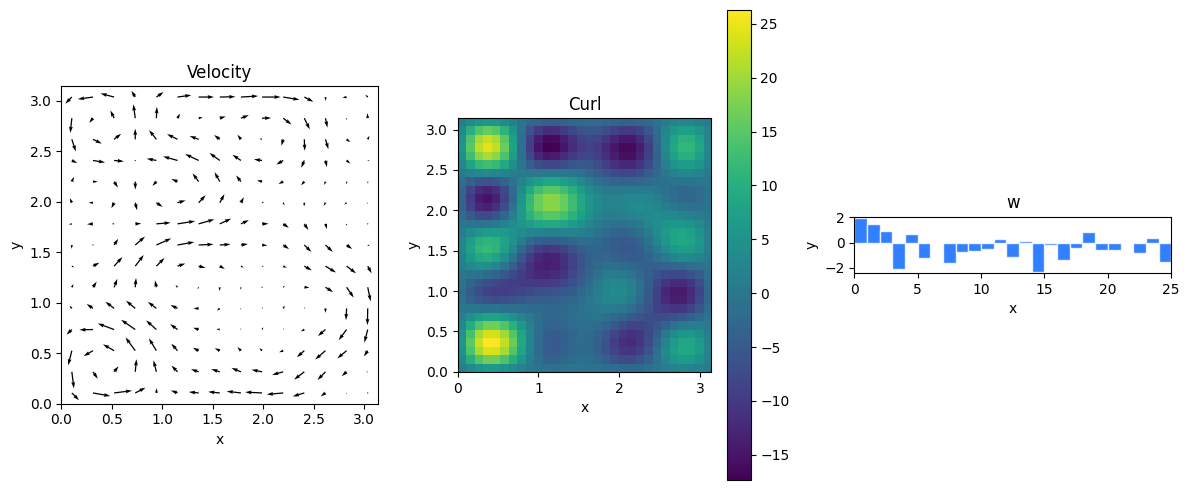

In [5]:
# N x [k1 k2 eig]
basis_fields = init_basis_fields()
#print("Initialized basis_fields:\n{}".format(basis_fields.numpy('i,k')))

w = init_w(random=True)
print("Initialized w = {}".format(w.numpy()))

velocity = reconstruct_velocity()
smoke = init_smoke()
#vis.plot({"vel": velocity, "curl": field.curl(velocity)})
vis.plot(get_visu_dict(vel=velocity, curl=True, w=w), same_scale=False)

In [6]:
# Precalculate advection tensor
# TODO use sparse matrices
C_k = np.zeros((N,N,N))
precalculate_advection()
C_k = tensor(C_k, instance('k'), channel('h,i'))
#print(C_k.native('k,h,i'))

## Update step

In [7]:
def step_w(w_curr, dt = 0.2, viscosity = 1.):
    # store kinetic energy of the velocity field
    e_1 = math.l2_loss(w_curr)*2 # the pytorch function l2_loss calculates sum(sqr(x))/2 
    
    # Matrix-vector product for advection
    dw = math.dot(math.dot(w_curr, ['k'], C_k, ['h']), ['i'], w_curr, ['k'])
    # Explicit Euler Integration 
    # TODO RK4
    w_curr += dw * dt
    
    # Energy after time step
    e_2 = math.l2_loss(w_curr)*2
    # Renormalize energy
    w_curr *= math.sqrt(e_1/e_2)
    
    # Dissipate energy for viscosity
    eig = rename_dims(basis_fields.k['eig'], 'i', 'k')
    w_curr *= math.exp(eig * dt * viscosity)
    
    # TODO add external forces
    # w_curr += f

    return w_curr

## Run the Simulation

In [8]:
#trajectory = [smoke]
w = init_w(random=True)/N
velocity = reconstruct_velocity()
smoke = init_smoke()

vel_traj = [velocity]
w_traj = [w]
smoke_traj = [smoke]

start_time = time.time()

for i in range(99):
    # Simulate
    w = step_w(w, dt = 0.1, viscosity=0.0)
    velocity = reconstruct_velocity()
    smoke = advect.mac_cormack(smoke, velocity, dt=.1)
    # Save trajectory
    vel_traj.append(velocity)
    w_traj.append(w)
    smoke_traj.append(smoke)

end_time = time.time()
print("Simulation finished in {} seconds".format(end_time-start_time))

Simulation finished in 12.64137601852417 seconds


## Plot results

In [9]:
# For display
w_VIS_SCALE = 100
w_traj_scaled = [w*w_VIS_SCALE for w in w_traj]

# For rescaled velocity field:
#vel_traj = stack(list(map(get_rescaled_vel, vel_traj)), batch('time'))
vel_traj_time = stack(vel_traj, batch('time'))
curl_traj_time = stack(list(map(field.curl, vel_traj)), batch('time'))
w_traj_time = stack(list(map(get_w_point_cloud, w_traj_scaled)), batch('time'))
smoke_traj_time = stack(smoke_traj, batch('time'))

# Pre-vis scaling:
#vis.plot([vel_traj_time.time[0], curl_traj_time.time[0], w_traj_time.time[0]])

In [10]:
vis.plot({
        "Smoke marker": smoke_traj_time,
        "Velocity": vel_traj_time,
        "Curl": curl_traj_time,
        "w (*{})".format(w_VIS_SCALE): w_traj_time
    },
    animate='time',
    same_scale=False,
)

<Figure size 640x480 with 0 Axes>

# Comparison with Traiditional Fluid Simulation

## Run Fluid Simulation

In [11]:
w = init_w(random=True)/N
print(w.native())
velocity = reconstruct_velocity()
smoke = init_smoke()

trajectory_v = [velocity]
trajectory_curl = [field.curl(velocity)]
trajectory_smoke = [smoke]

start_time = time.time()

for i in range(99):
    velocity = advect.semi_lagrangian(velocity, velocity, dt=0.1)
    velocity, _ = fluid.make_incompressible(velocity)
    smoke = advect.mac_cormack(smoke, velocity, dt=0.1)

    trajectory_v.append(velocity)
    trajectory_curl.append(field.curl(velocity))
    trajectory_smoke.append(smoke)
    
    
end_time = time.time()
print("Simulation finished in {} seconds".format(end_time-start_time))

trajectory_v = math.stack(trajectory_v, batch('time'))
trajectory_curl = math.stack(trajectory_curl, batch('time'))
trajectory_smoke = math.stack(trajectory_smoke, batch('time'))

tensor([ 0.0771,  0.0595,  0.0360, -0.0842,  0.0271, -0.0494, -0.0017, -0.0642,
        -0.0301, -0.0275, -0.0197,  0.0097, -0.0444,  0.0037, -0.0927, -0.0087,
        -0.0554, -0.0158,  0.0321, -0.0249, -0.0237, -0.0025, -0.0331,  0.0132,
        -0.0623])
Simulation finished in 26.836983919143677 seconds


## Plot Results of Traditional Fluid Simulation

In [12]:
vis.plot([trajectory_smoke, trajectory_v, trajectory_curl], animate='time', same_scale=False)

<Figure size 640x480 with 0 Axes>